In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from database_credentials import get_database_url

In [2]:
plt.style.use('ggplot')

In [12]:
def check_for_missing_values(data):
    '''Print whether or not data contains missing data 
    along with the number of missing entries
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    '''
    
    valid_mask = data.isnull()
    data_contains_missing_values = valid_mask.any().any()
    print("Contains missing values:", data_contains_missing_values)

    if (data_contains_missing_values):
        number_of_missing_values = valid_mask.sum().sum()
        print("Number of missing values:", number_of_missing_values)
    
def check_for_duplicate_ids(data):
    '''Print whether or not data contains duplicate 
    Steam IDs along with the number of duplicates
    
    Args:
        data (dataframe): dataframe to be checked
        
    Returns:
        None
    '''
    
    unique_id_mask = data['steam_id'].duplicated()
    data_contains_duplicates = unique_id_mask.any()
    print("\nContains duplicate Steam IDs:", data_contains_duplicates)

    if (data_contains_duplicates):
        number_of_duplicates = len(data[unique_id_mask])
        print("Number of duplicate Steam IDs:", number_of_duplicates)
        
def display_info(data):
    '''Display the column names, number of rows, and information 
    regarding missing or duplicate values for a dataframe
    
    Args:
        data (dataframe): dataframe for which information will
                          be displayed
    Returns:
        None
    '''
    
    print("Column Name and Types:\n{0}\n".format(data.dtypes))
    print("Number of rows: {0}\n".format(data.shape[0]))
    check_for_missing_values(data)
        
def mask_duplicate_ids(data):
    '''Mask rows containing duplicate Steam IDs
    
    Args:
        data (dataframe): dataframe with duplicate Steam IDs

    Returns:
        masked_data (dataframe): a copy of data without duplicate
                                 Steam IDs
    '''
    
    duplicate_id_mask = ~data['steam_id'].duplicated()
    masked_data = data[duplicate_id_mask]
    return masked_data

def get_review_rating(review):
    '''Get the rating from review if applicable
    
    Args: 
        review (str): Steam review
        
    Returns:
        rating_numerator (float/None): rating within the review
    '''
    
    rating_numerator = None
    match = re.search(r'\d+(\.\d+)?/10', review)
    if (match):
        rating = match[0]
        split_rating = rating.split('/')
        rating_numerator = float(split_rating[0])
        
    return rating_numerator

def round_rating(rating):
    '''Round rating to the nearest integer
    
    Args:
        rating (float): rating to be rounded
        
    Returns:
        rounded_rating (float): rating rounded to nearest integer
    '''
    
    rounded_rating = round(rating, 0)
    return rounded_rating

def graph_word_cloud(corpus):
    """Graph a word cloud based on corpus
    
    Args:
        corpus (str): contains the text data
    
    Returns:
        None
    """
    
    word_cloud = WordCloud(width=1600, height=800, collocations=False).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def get_percentage_change(initial_value, final_value):
    change = (initial_value - final_value) / initial_value
    percentage_change = round(change * 100, 2)
    return percentage_change

In [4]:
# connect to database
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect() 

In [5]:
# load data
review_query = '''
    SELECT 
        steam_id,
        user_review,
        FROM_UNIXTIME(timestamp_updated) AS timestamp_updated,
        recommends_game
    FROM reviews;
'''
review_data = pd.read_sql(review_query, connection)

user_query = '''
    SELECT 
        steam_id,
        CEIL(total_minutes_played / 60) AS total_hours_played,
        FROM_UNIXTIME(timestamp_last_played) AS timestamp_last_played
    FROM users;
'''
user_data = pd.read_sql(user_query, connection)

I first start by getting a feel for the review and user data.

In [6]:
display(review_data.head(3))
display_info(review_data)
check_for_duplicate_ids(review_data)

,steam_id,user_review,timestamp_updated,recommends_game
0,76561198109804262,The Game is smooth with great graphics. It sho...,2015-01-14 08:40:12,1
1,76561198144109929,AMAZING Best thing ever. Great graphics for a ...,2015-01-14 06:02:29,1
2,76561198074106169,Best f2p game out there,2015-01-14 03:20:10,1


Column Name and Types:
steam_id                     object
user_review                  object
timestamp_updated    datetime64[ns]
recommends_game               int64
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3


In [7]:
display(user_data.head(3))
display_info(user_data)
check_for_duplicate_ids(review_data)

,steam_id,total_hours_played,timestamp_last_played
0,76561198109804262,1007,2019-05-07 04:44:48
1,76561198144109929,157,2020-01-07 19:00:17
2,76561198074106169,238,2019-10-25 14:07:33


Column Name and Types:
steam_id                         object
total_hours_played                int64
timestamp_last_played    datetime64[ns]
dtype: object

Number of rows: 149999

Contains missing values: False

Contains duplicate Steam IDs: True
Number of duplicate Steam IDs: 3


Then get rid of duplicate Steam IDs using boolean masks, extract ratings from reviews and trim ratings greater than twelve (approximately 4% of the ratings) to deal with sparse ratings along with extreme outliers.

In [8]:
review_data = mask_duplicate_ids(review_data)
user_data = mask_duplicate_ids(user_data)

In [9]:
review_data['rating'] = review_data['user_review'].apply(get_review_rating)
reviews_with_ratings = review_data.dropna()
outlier_rating_mask = (reviews_with_ratings['rating'] < 13)
trimmed_reviews = reviews_with_ratings[outlier_rating_mask]

In [16]:
number_ratings_initial = reviews_with_ratings.shape[0]
number_ratings_final = trimmed_reviews.shape[0]
percentage_ratings_trimmed = get_percentage_change(
    number_ratings_initial,
    number_ratings_final
)

print("Ratings before trimming:", number_ratings_initial)
print("Ratings after trimming:", number_ratings_final)
print("Percentage of ratings trimmed:", percentage_ratings_trimmed)

Ratings before trimming: 10357
Ratings after trimming: 9953
Percentage of ratings trimmed: 3.9


Display the review containing the most extreme outlier

In [17]:
ratings = reviews_with_ratings['rating']
outlier_index = reviews_with_ratings[np.isinf(ratings)].index[0]
reviews_with_ratings.loc[outlier_index, 'user_review']

'Best Game I have Played 2SPOOKY4ME 99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999/10'

I use the ratings as they are to create a violinplot while rounding the ratings used for
the countplot to reduce the number of bins.

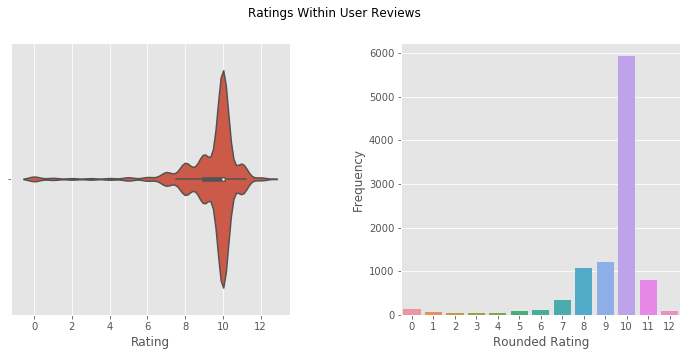

In [22]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 5), 
    squeeze=False
)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
axes = axes.flatten()

rating_violin = sns.violinplot(
    x=trimmed_reviews['rating'], 
    ax=axes[0]
)
rating_violin.set(xlabel='Rating')

rounded_ratings = trimmed_reviews['rating'].apply(round_rating)
rating_bargraph = sns.countplot(
    x=rounded_ratings.astype(int),
    ax=axes[1]
)
rating_bargraph.set(xlabel='Rounded Rating', ylabel='Frequency')
plt.suptitle('Ratings Within User Reviews')
plt.show()

The violin plot determines ratings beyond the approximate interval [7.5, 11] as outliers
and shows the median of the ratings to be 10. On a side note, both show that the mode of the ratings is 10 and that ratings are left-skewed and tend to be higher.

In [ ]:
corpus = ' '.join(review_data.loc[review_data['recommends_game'] == True, 'user_review'])
graph_word_cloud(corpus)